In [6]:
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from outputsmearing_forest import osRandomForest
from sklearn.linear_model import Ridge

import variable_bootstrap_forest
import pickle
import itertools
from scipy.stats import ttest_rel
import scipy


def get_best_dict_vals(indexes, dict):
    combos = [i for i in itertools.product(*indexes)]
    best = 1000000000
    for i in dict:
        if dict[i] < best and i in combos:
            best = dict[i]
            best_combo = i
    return best_combo, best

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.dpi']=600
plt.rcParams["font.family"] = "serif"

Figure 1

In [7]:
X,y = make_friedman1(2200, noise=0, random_state=3638)
base_noise = 3*np.std(y) # mean of added noise
X_train, X_test, y_train_clean, y_test = train_test_split(X,y, test_size=10/11, random_state=3638)

random_generator = np.random.default_rng(35421)
indi_noises = random_generator.uniform(0, 2*base_noise, 200) # only adding noise to training set

y_train = y_train_clean + [random_generator.normal(0, i) for i in indi_noises]



test_points = np.linspace(0,2,20)
conv_probs = [np.exp(-i) for i in indi_noises]
z = []
for lop in range(10):
    y = []
    for tp in test_points:
        model = variable_bootstrap_forest.vbRandomForest(n_estimators=500, bootstrap=True, probs_power=tp, max_features=1, n_jobs=-1, random_state=25*lop)
        model.fit(X_train, y_train, probs=conv_probs)
        y_pred = model.predict(X_test)
        y.append(r2_score(y_test, y_pred))

    z.append(y)

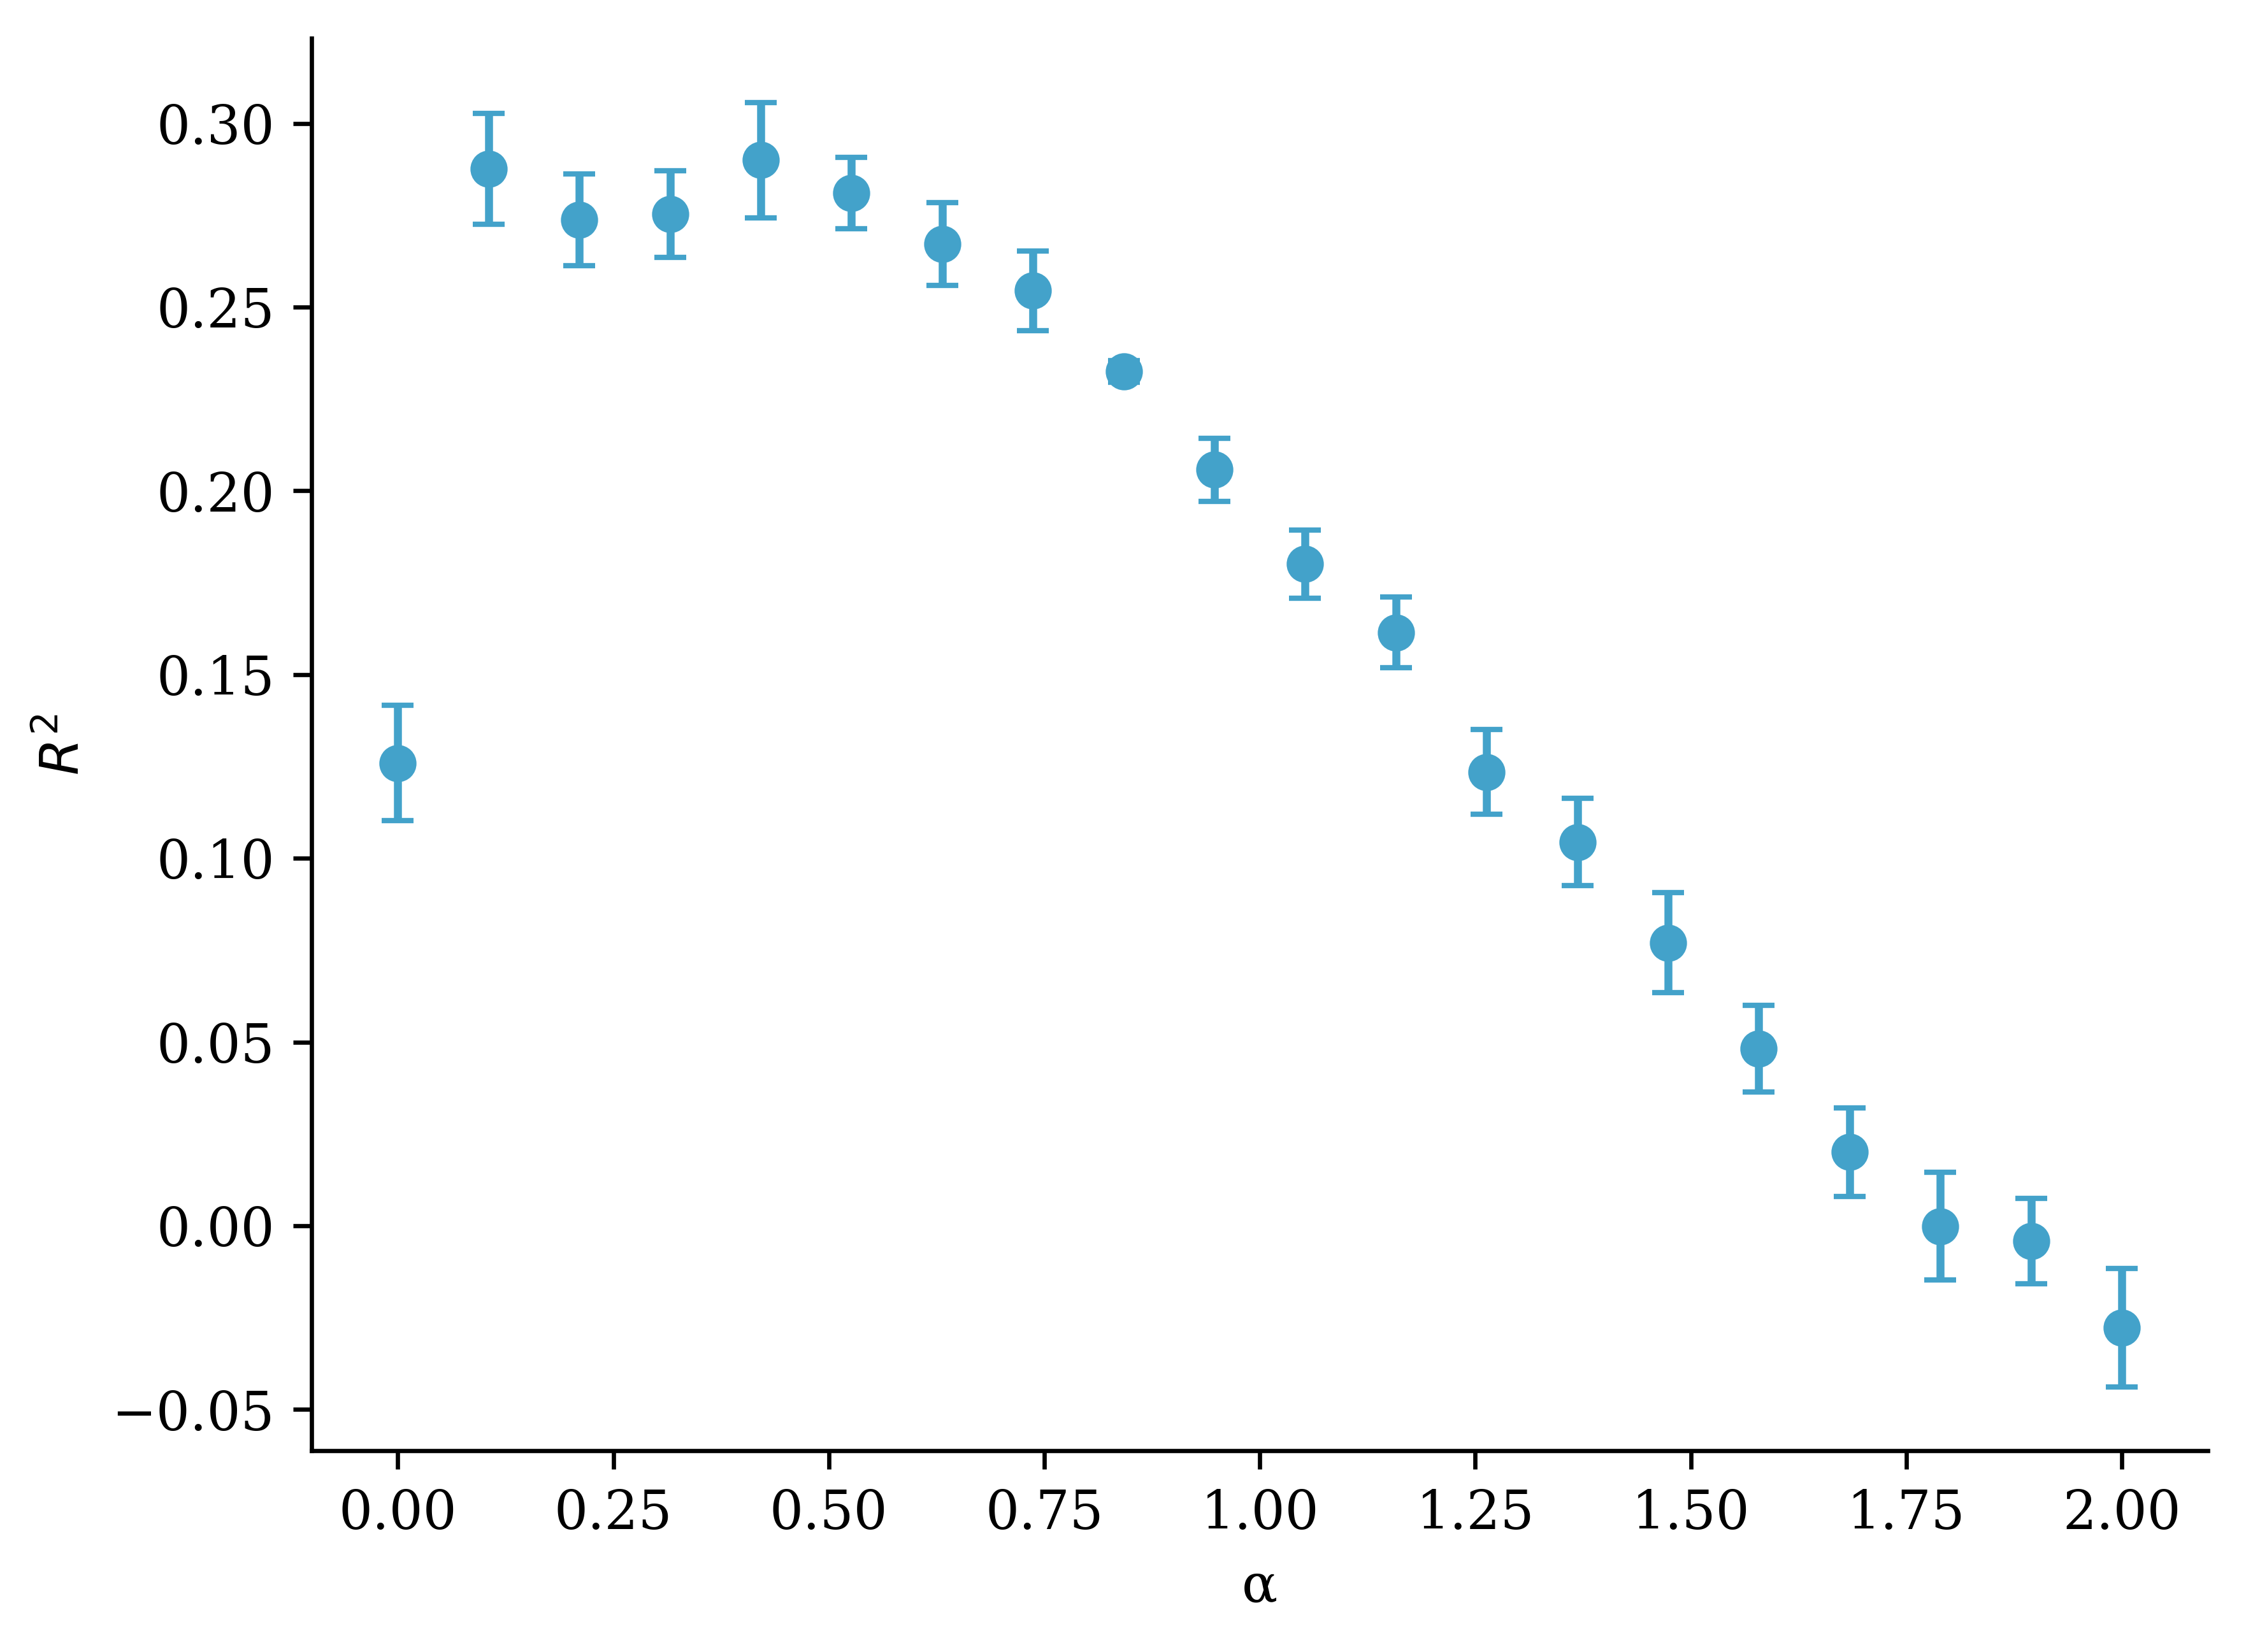

In [8]:
fig, ax = plt.subplots(1,1)
ax.errorbar(test_points, np.mean(z, axis=0),np.std(z, axis=0), fmt='o', color='#43a2ca', capsize=3)
ax.set_xlabel("α")
ax.set_ylabel("$R^2$")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Figure 2


In [7]:
size = 1

RS = 239400

noise_vals = np.linspace(0, 8, 17)

X,y = make_friedman1(2200, noise=0, random_state=RS)
base_noise = np.std(y) # mean of added noise
X_train, X_test, y_train_clean, y_test = train_test_split(X,y, test_size=10/11, random_state=RS)
random_generator = np.random.default_rng(35421)
indi_noises = random_generator.uniform(0, 2*base_noise, 200) # only adding noise to training set

best_points = []
best_points_r = []
best_r2s = []
best_r2s_r = []
for noise in noise_vals:

    test_points = np.linspace(0,2,10)
    conv_probs = [np.exp(-i*noise) for i in indi_noises]
    
    z = []
    for lop in range(int(20*size)):
        y_train = y_train_clean + [random_generator.normal(0, i*noise) for i in indi_noises]
        y = []
        for tp in test_points:
            model = variable_bootstrap_forest.vbRandomForest(n_estimators=int(500*size), bootstrap=True, probs_power=tp, max_features=1, n_jobs=-1, random_state=lop)
            model.fit(X_train, y_train, probs=conv_probs)
            y_pred = model.predict(X_test)
            y.append(r2_score(y_test, y_pred))
        z.append(y)
    bvs = []
    brs = []
    for i in z:
        bvs.append(test_points[np.argmax(i)])
        brs.append(np.max(i))
    
    best_points.append(np.mean(bvs))
    best_points_r.append(np.std(bvs))

    best_r2s.append(np.mean(brs))
    best_r2s_r.append(np.std(brs))
    


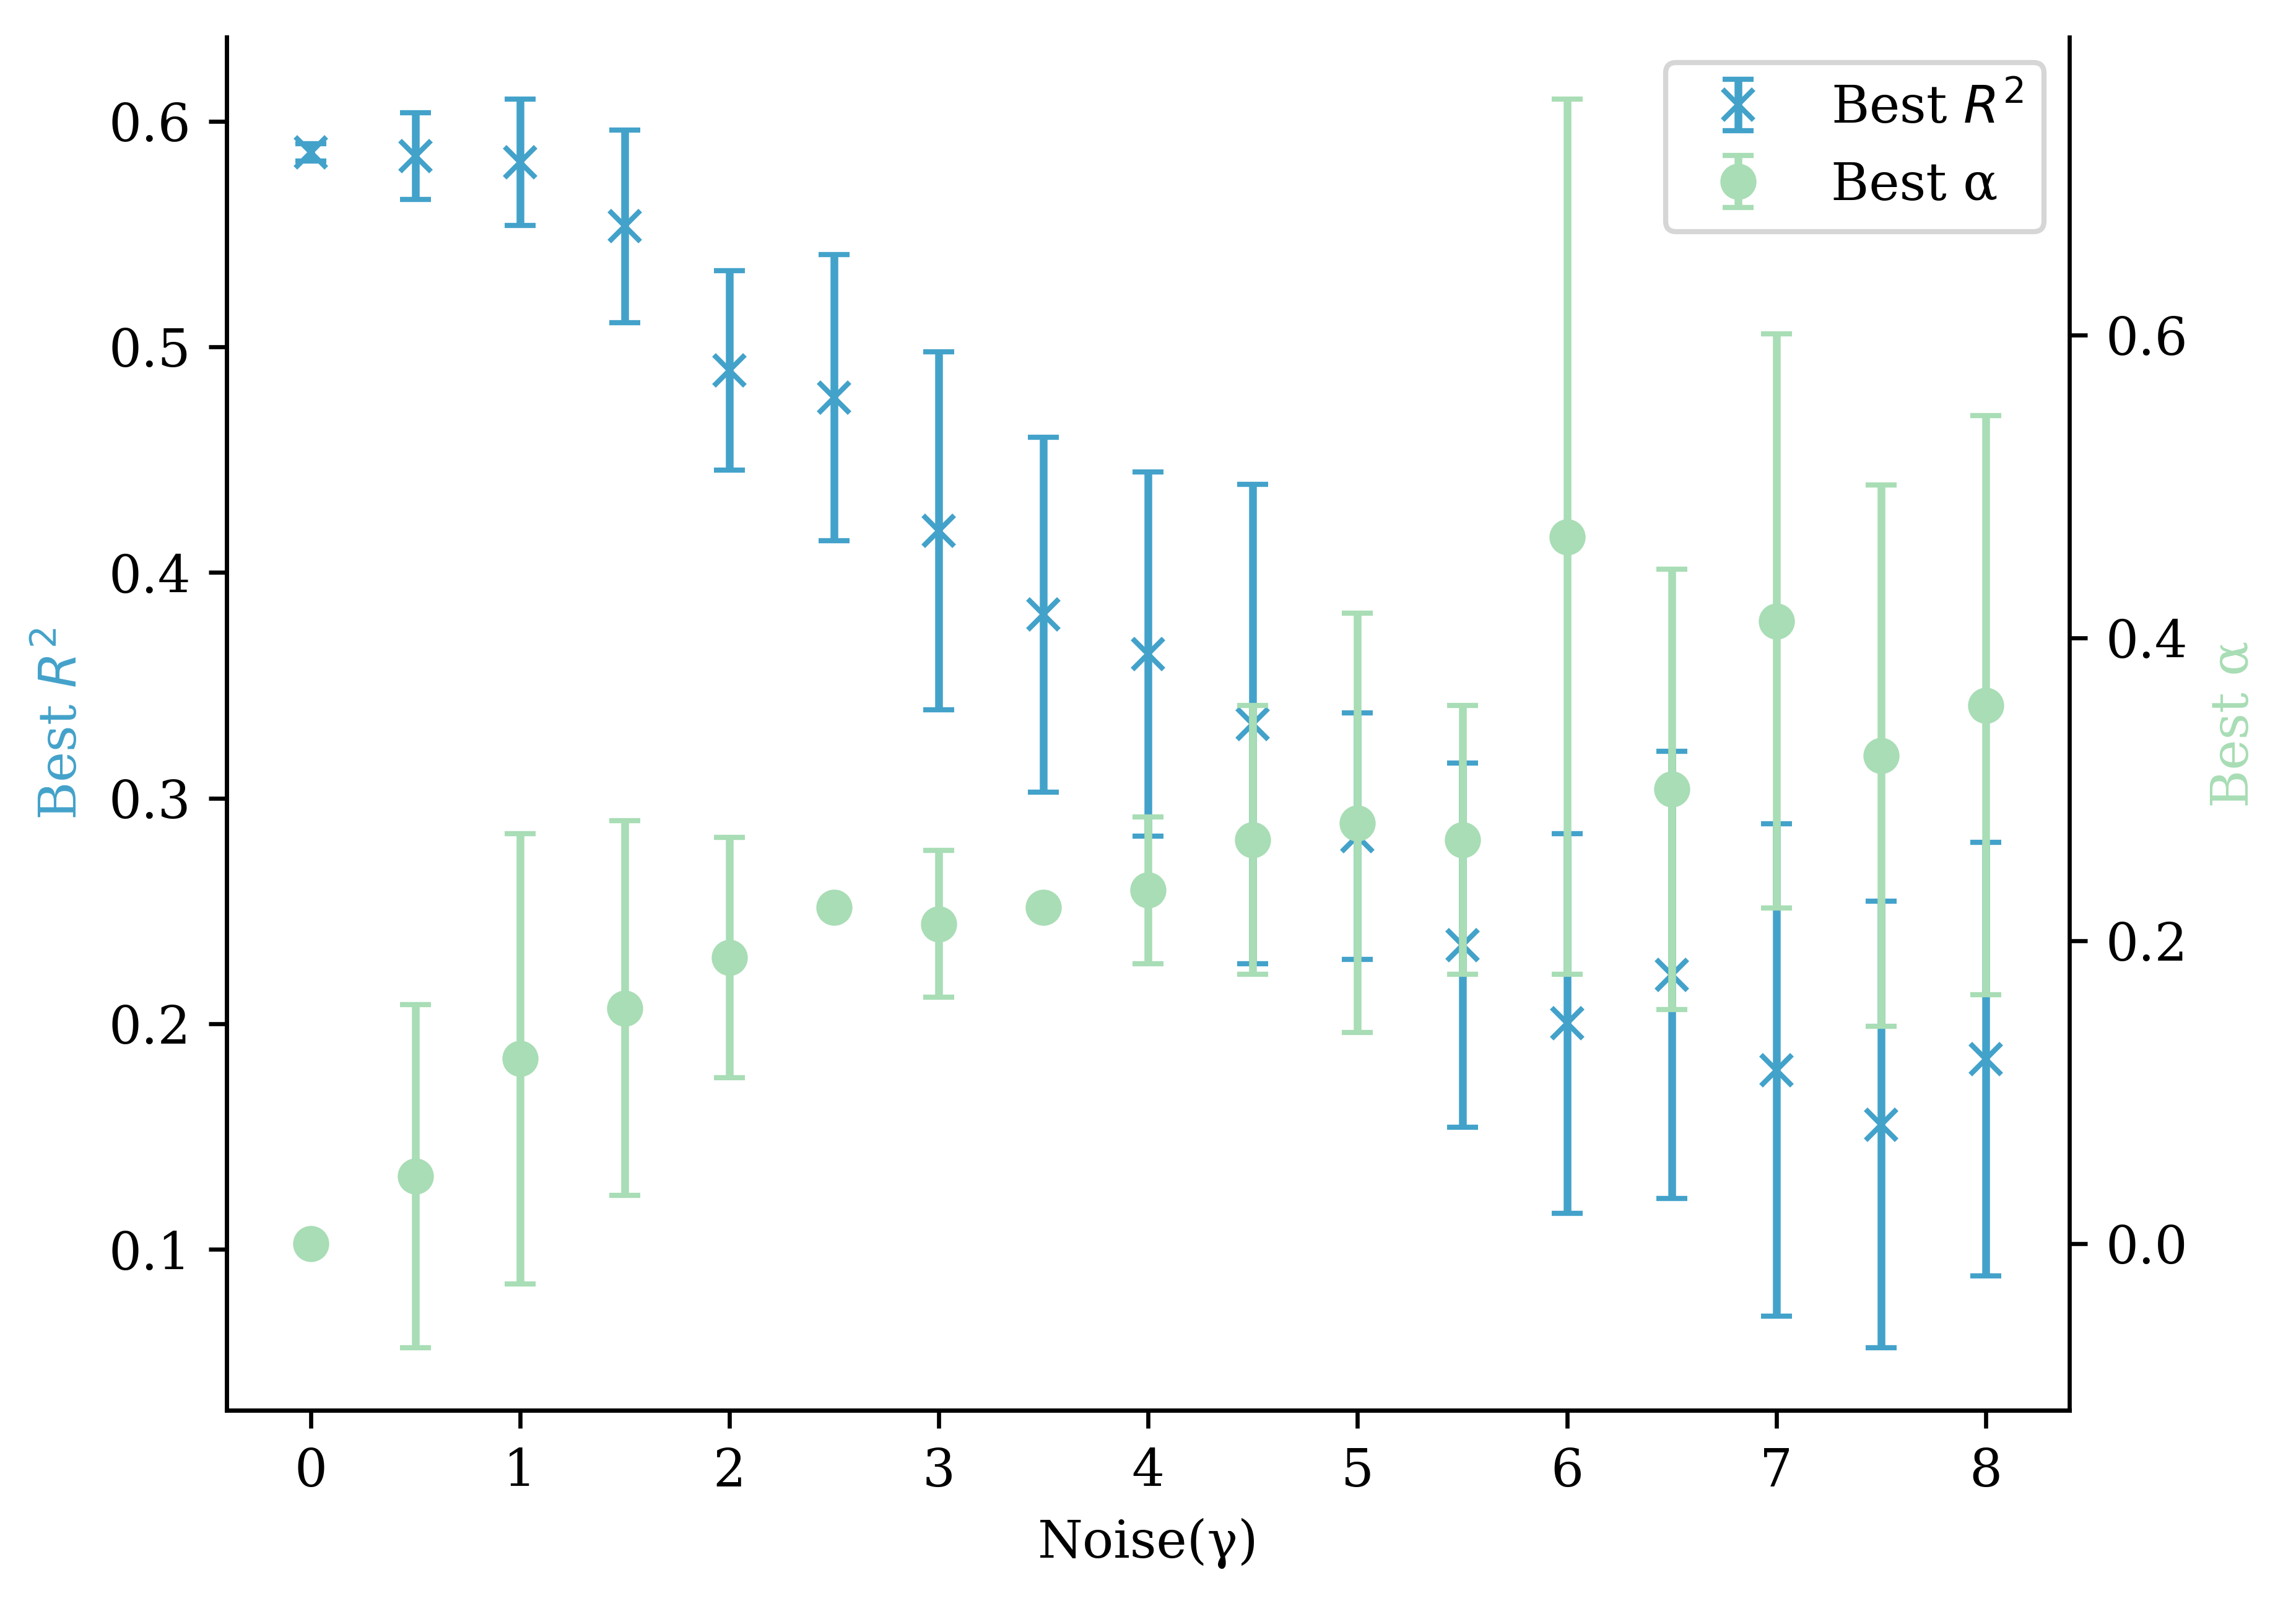

In [11]:
# plot on same axis best points against noise vals and best r2s against noise vals
fig, ax1 = plt.subplots()

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.errorbar(noise_vals, best_r2s, yerr=np.transpose(best_r2s_r), color='#43a2ca', fmt='x', capsize=3, label="Best $R^2$")
ax1.set_ylabel("Best $R^2$", color='#43a2ca')

ax2 = ax1.twinx()
ax2.errorbar(noise_vals, best_points, yerr=np.transpose(best_points_r), color='#a8ddb5', fmt='o', capsize=3, label="Best α")
ax2.spines['top'].set_visible(False)

# show both legends in same box
lines, labels = ax1.get_legend_handles_labels() 
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0)

ax1.set_xlabel("Noise(γ)")
ax2.set_ylabel("Best α", color='#a8ddb5')


plt.show()

Figure 5

In [11]:

X,y = make_friedman1(2200, noise=0, random_state=3638)
base_noise = 1*np.std(y) # mean of added noise
X_train, X_test, y_train_clean, y_test = train_test_split(X,y, test_size=10/11, random_state=3638)

random_generator = np.random.default_rng(35421)
indi_noises = random_generator.uniform(0, 2*base_noise, 200) # only adding noise to training set

y_train = y_train_clean + [random_generator.normal(0, i) for i in indi_noises]

indi_noises = [np.exp(-i) for i in indi_noises]

test_points = np.linspace(0,2,20)
z = []
for lop in range(10):
    y = []
    for tp in test_points:
        model = osRandomForest(n_estimators=500, bootstrap=True, power_smear=-tp, max_features=1.0, output_smear=2, n_jobs=-1, random_state=lop)
        model.fit(X_train, y_train, probs=indi_noises)
        y_pred = model.predict(X_test)
        y.append(r2_score(y_test, y_pred))

    z.append(y)
    


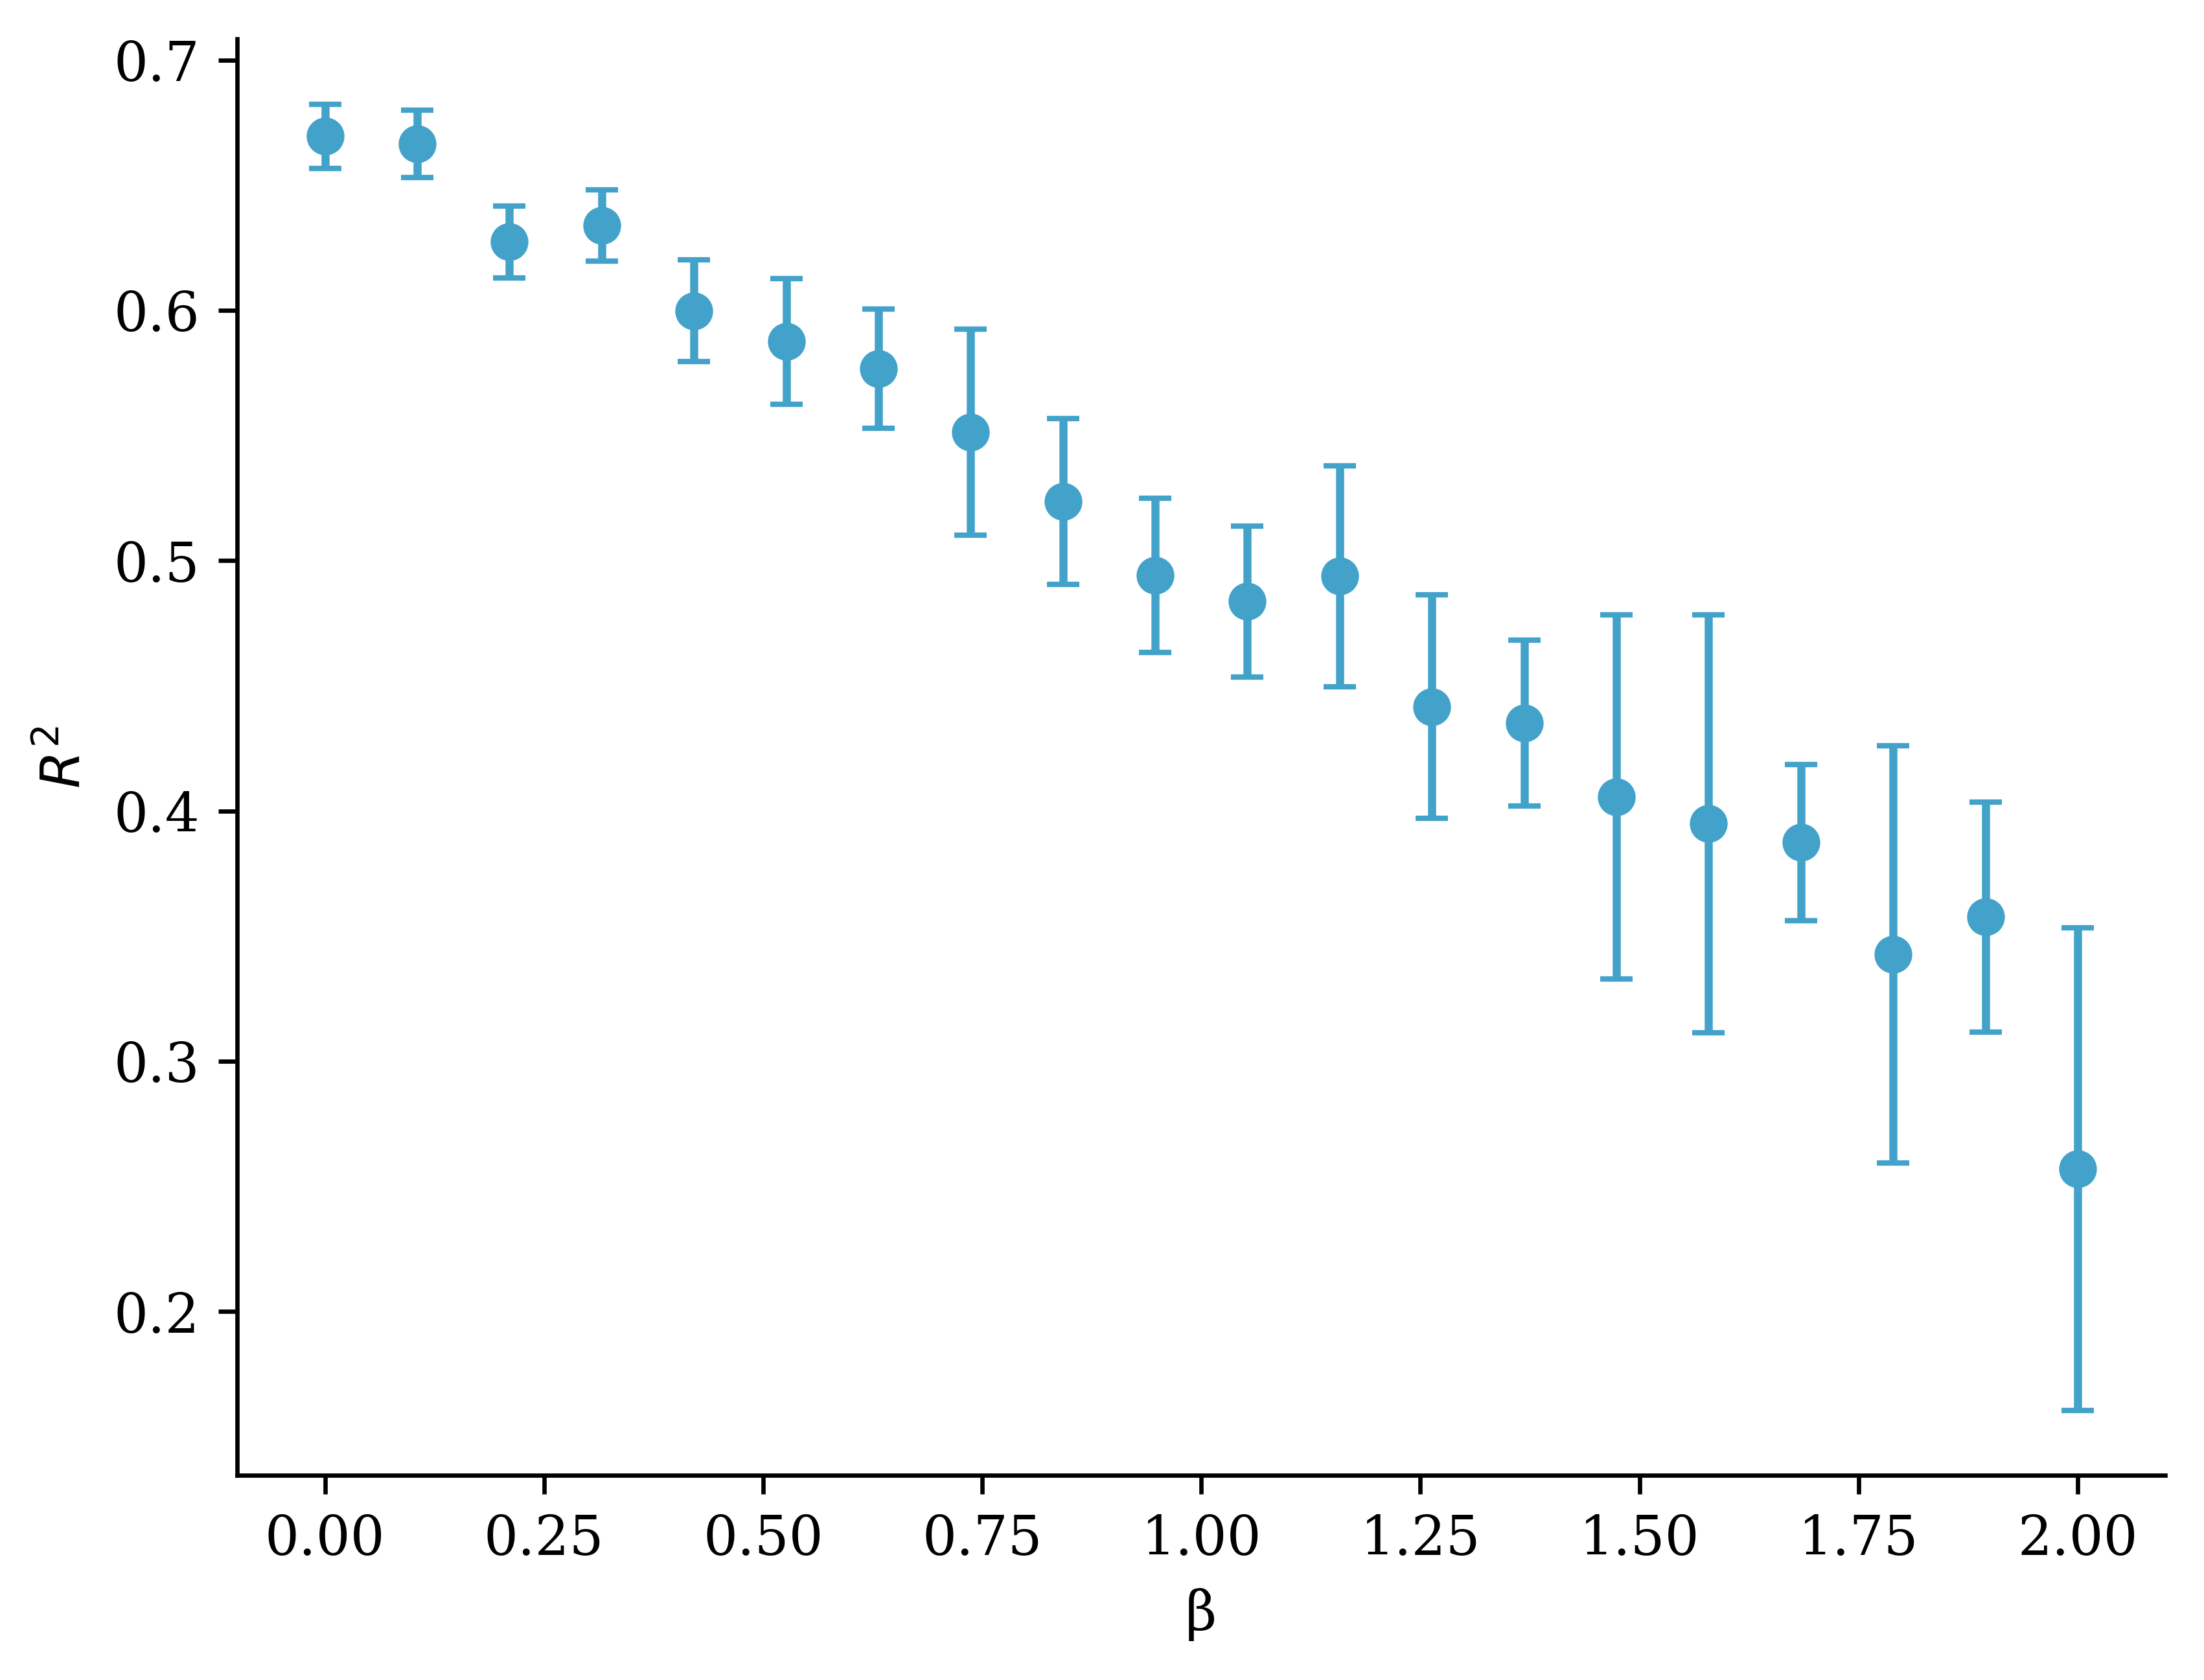

In [12]:
fig, ax = plt.subplots(1,1)


ax.errorbar(test_points, np.mean(z, axis=0),np.std(z, axis=0), fmt='o', color='#43a2ca', capsize=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("$R^2$")
ax.set_xlabel("β")
plt.show()

Figure 6

In [13]:
def noise_at_point(y, mean_plus):
    if y > mean_plus:
        return 1
    else:
        return 5

X,y = make_friedman1(2200, noise=0, random_state=3638)
base_noise = 1*np.std(y) # mean of added noise
X_train, X_test, y_train_clean, y_test = train_test_split(X,y, test_size=10/11, random_state=3638)

random_generator = np.random.default_rng(35421)

test_points = np.linspace(0,2,20)

y_2 = np.mean(y_train_clean)+np.std(y_train_clean)

indi_noises = [noise_at_point(i, y_2) for i in y_train_clean]
indi_noises = np.array(indi_noises)*base_noise/np.mean(indi_noises)

y_train = y_train_clean + [random_generator.normal(0, i) for i in indi_noises]
indi_noises = [np.exp(-i) for i in indi_noises]

z2 = []
for lop in range(10):

    y2 = []
    for tp in test_points:
        model = osRandomForest(n_estimators=2500, bootstrap=True, power_smear=-tp, max_features=1.0, output_smear=1, n_jobs=-1, random_state=lop)
        model.fit(X_train, y_train, probs=indi_noises)
        y_pred = model.predict(X_test)
        y_err = [(y_test[i]-y_pred[i])**2 for i in range(len(y_test))]
        y2.append(r2_score(y_test, y_pred))
        
    z2.append(y2)


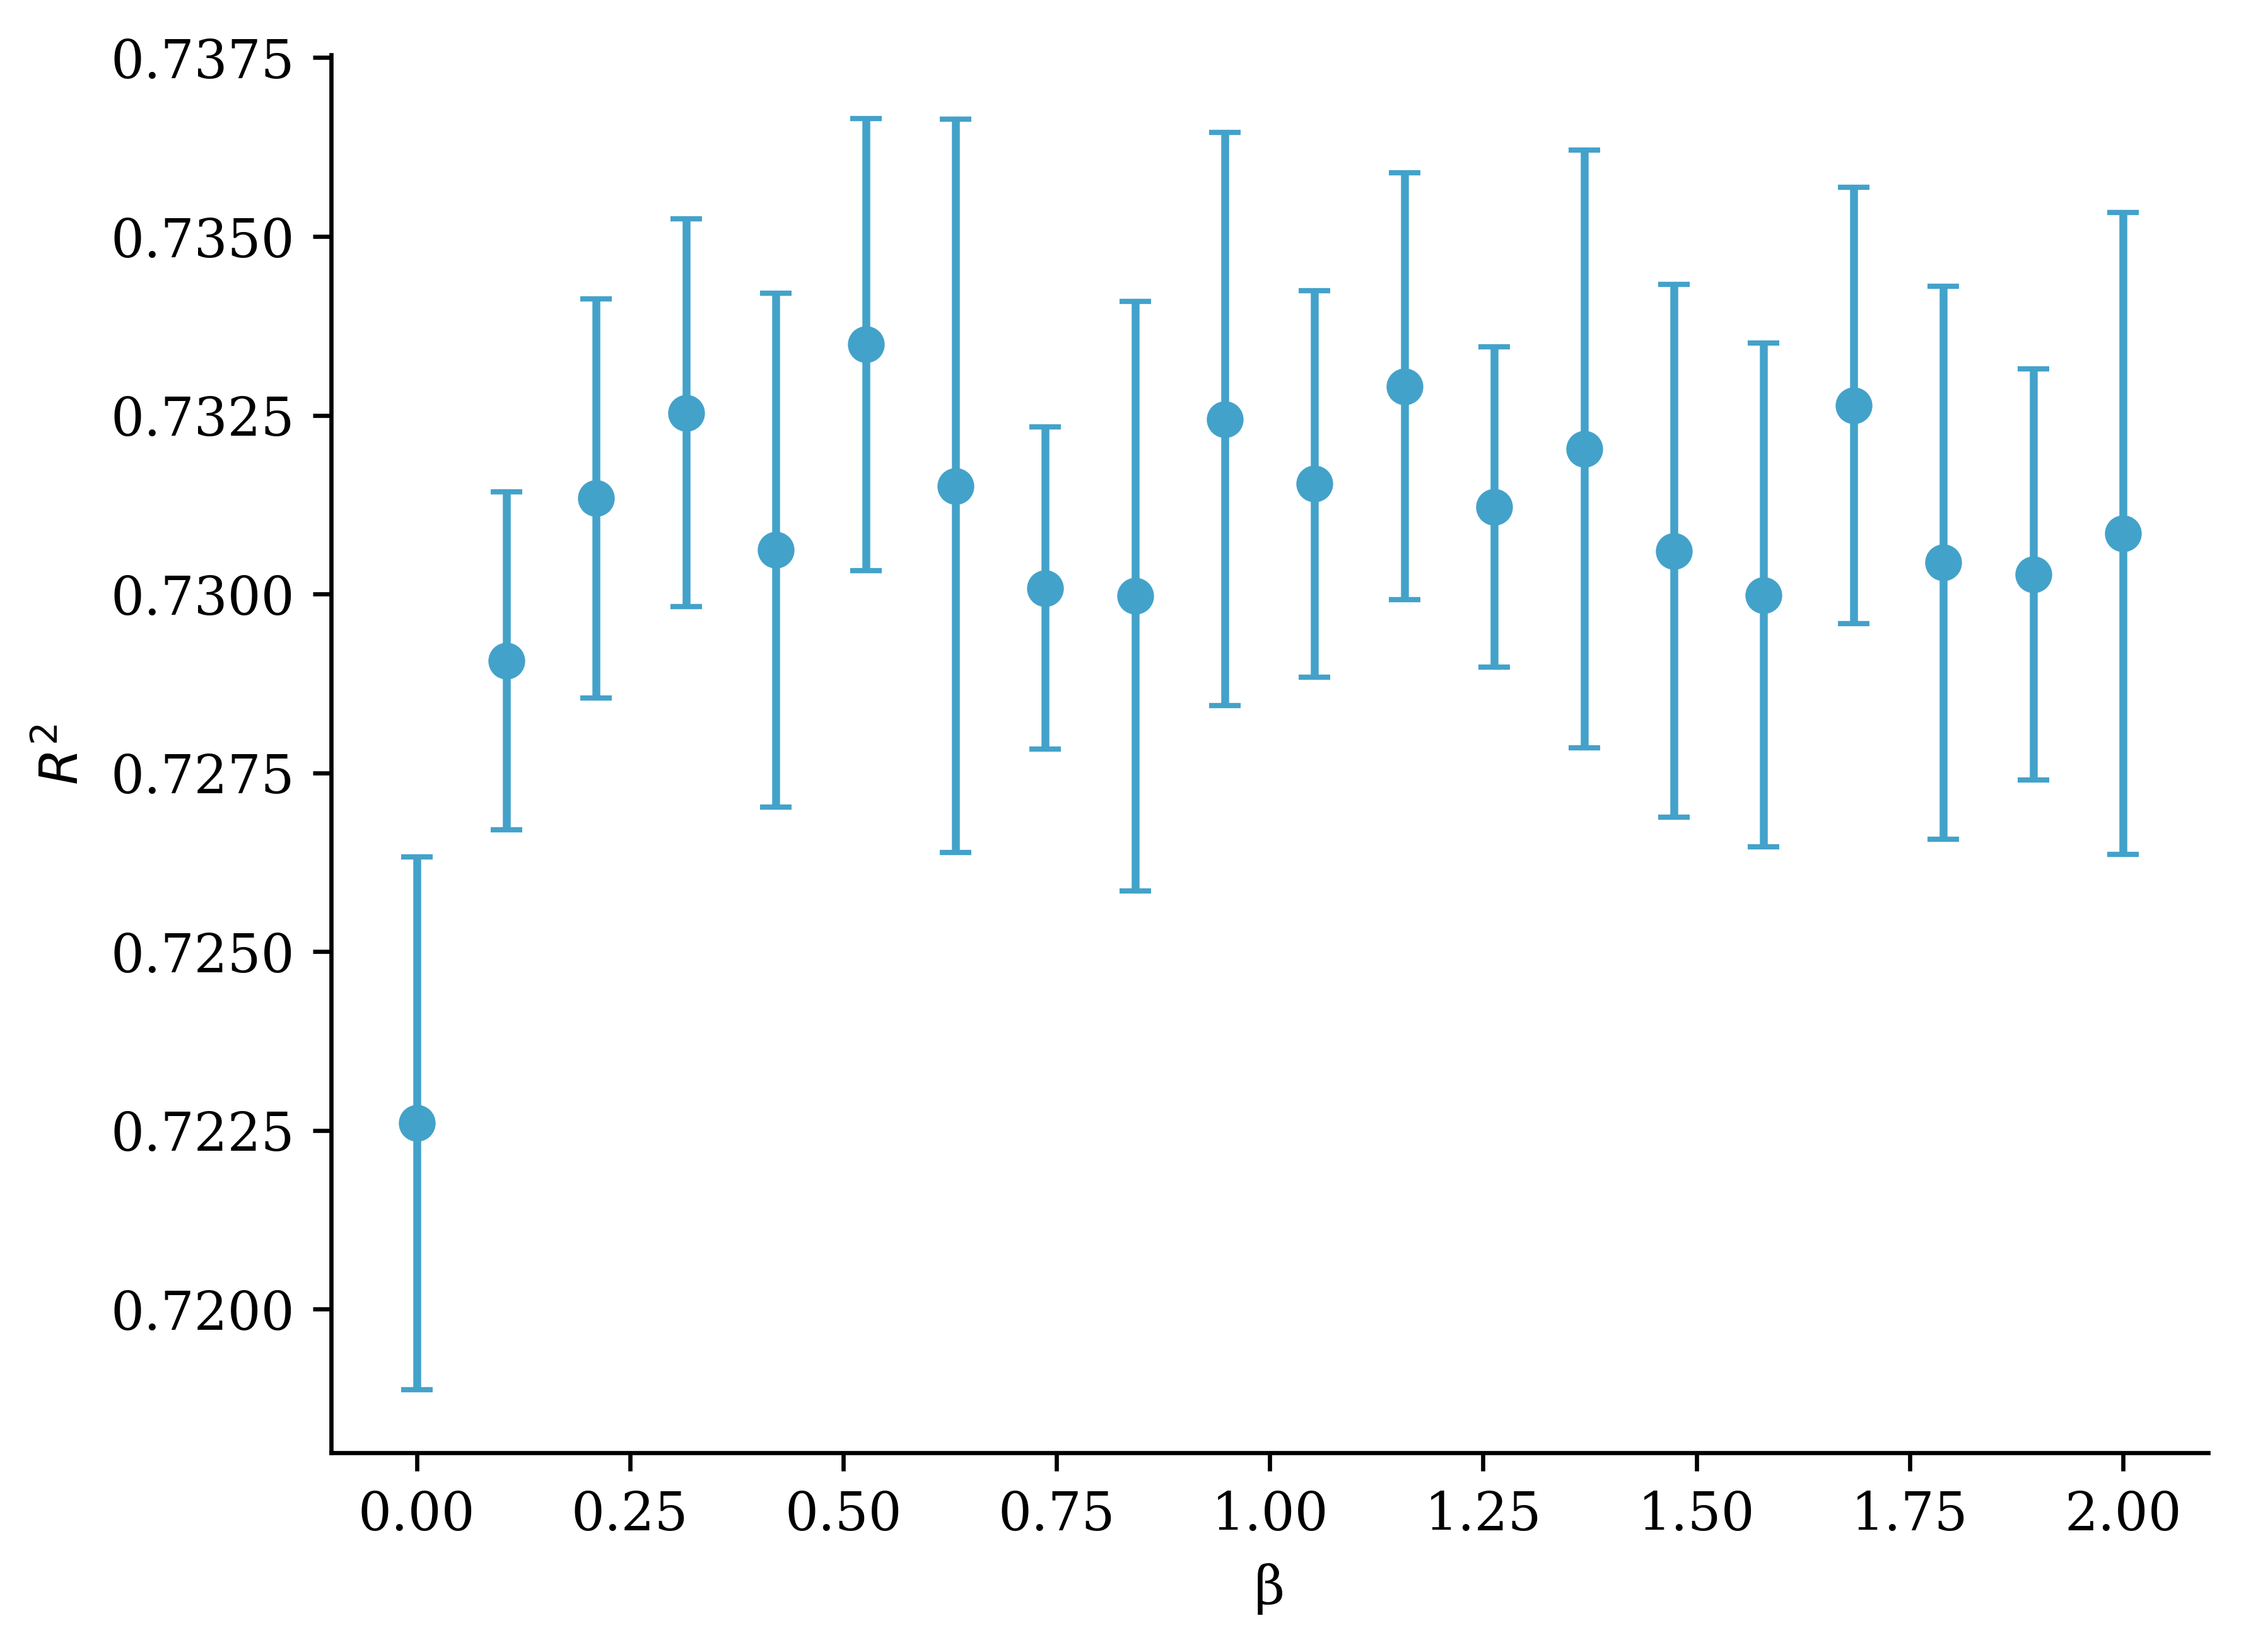

In [14]:
fig, ax = plt.subplots(1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.errorbar(test_points, np.mean(z2, axis=0),np.std(z2, axis=0), fmt='o', capsize=3, color='#43a2ca')
ax.set_ylabel("$R^2$")
ax.set_xlabel("β")

plt.show()

Figure 3

In [15]:
X,y = make_friedman1(2200, noise=0, random_state=3638)
base_noise = 3*np.std(y) # mean of added noise
X_train, X_test, y_train_clean, y_test = train_test_split(X,y, test_size=10/11, random_state=3638)

random_generator = np.random.default_rng(35421)
indi_noises = random_generator.uniform(0, 2*base_noise, 200) # only adding noise to training set

y_train = y_train_clean + [random_generator.normal(0, i) for i in indi_noises]

test_points = np.linspace(0,2,20)
base_conv_probs = [np.exp(-i) for i in indi_noises]

z = []
for lop in range(10):
    y = []
    for tp in test_points:
        model = variable_bootstrap_forest.vbRandomForest(n_estimators=500, bootstrap=True, max_features=1, n_jobs=-1, random_state=lop, probs_power=0, weight_power=tp)
        model.fit(X_train, y_train, sample_weight=conv_probs)
        y_pred = model.predict(X_test)
        y.append(r2_score(y_test, y_pred))

    z.append(y)
    


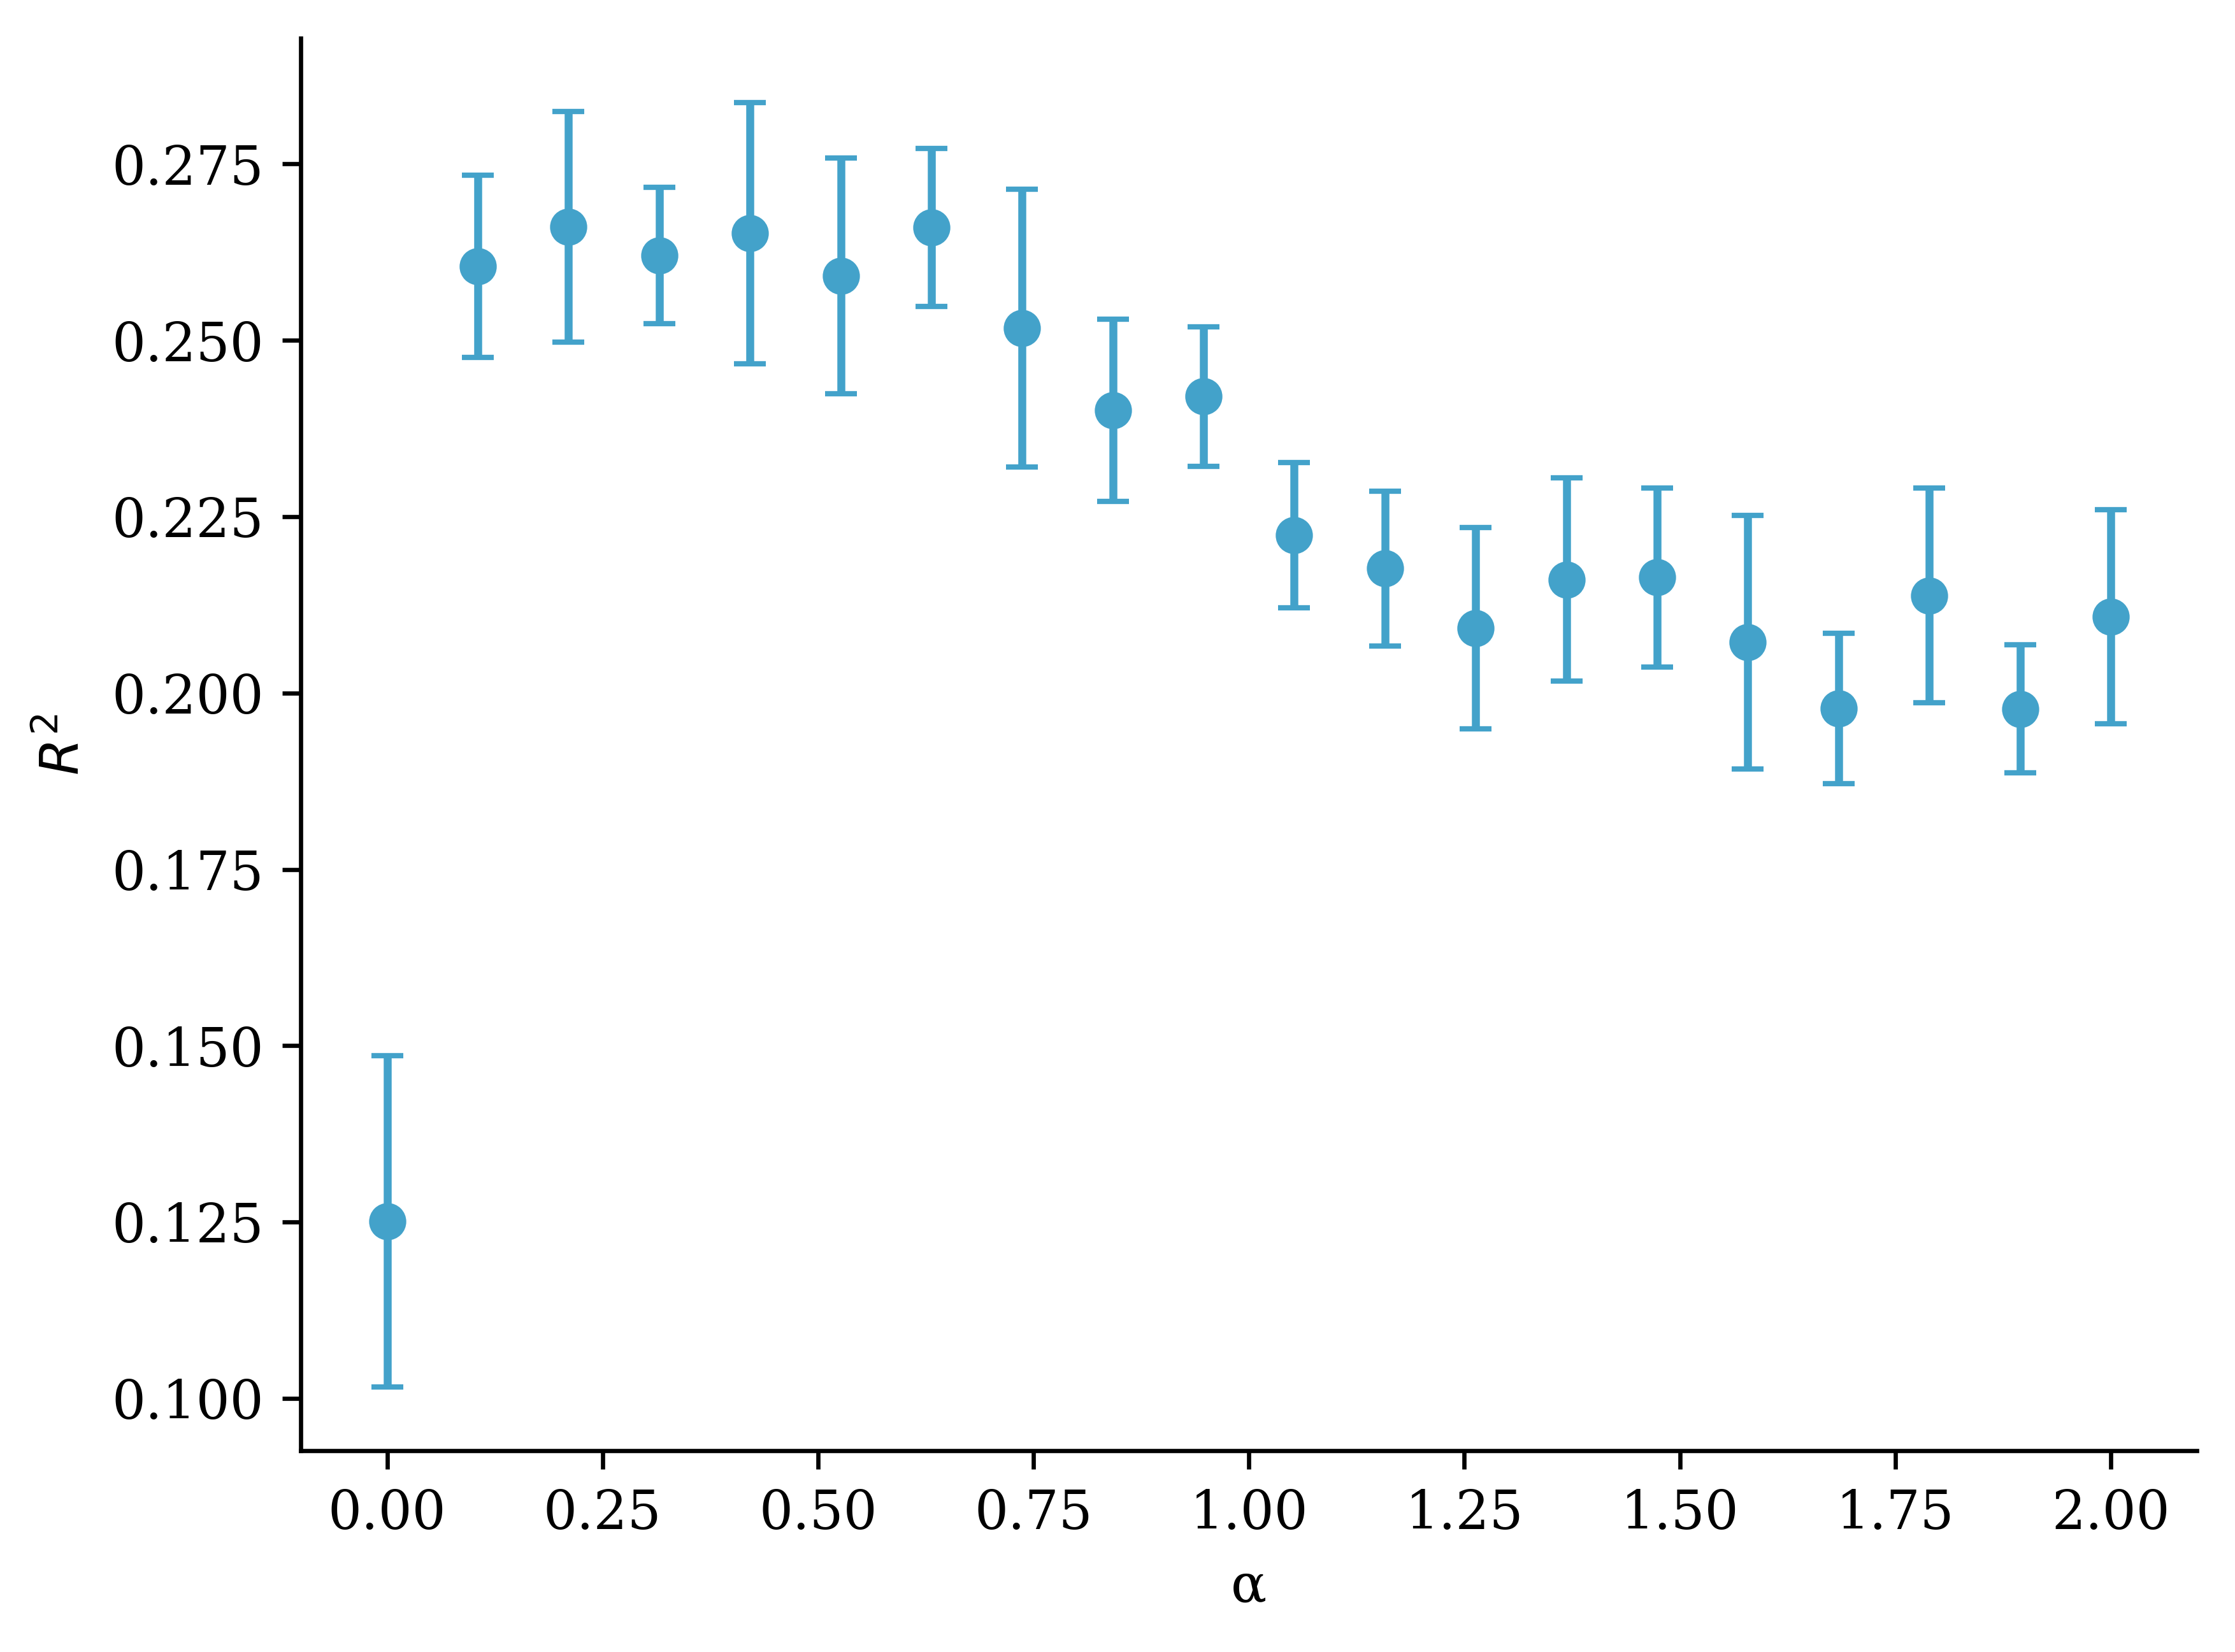

In [16]:
fig, ax = plt.subplots(1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.errorbar(test_points, np.mean(z, axis=0),np.std(z, axis=0), fmt='o', capsize=3, color='#43a2ca')
ax.set_ylabel("$R^2$")
ax.set_xlabel("α")
plt.show()

These results show that using sample weights imporves model performance when heterscedastic noise is present. Without weighting the samples ($\alpha$=0) the performance is much worse, increasing to a suffiecnt amount of weighting leads to a large improvement in model performance. The optimum value of $\alpha$ is similar to the optimum value of $\alpha$ for the parametric bootstrap, but unlike the parametric bootstrap the weighted random forest is relativly stable as $\alpha$ is increased beyond the optimum value. The benefit of weighting samples during splitting of the decision tree is weaker than that of the parametric boostrap. 

The usefulness of weighting the model during splitting will depend on the amount of noise present. We found the value of $\alpha$ that gave the best performance across a range of noise level and plotted the best values and the resulting $R^2$ values in figure X. 

In [12]:
RS = 239400

noise_vals = np.linspace(0, 8, 17)

X,y = make_friedman1(2200, noise=0, random_state=RS)
base_noise = np.std(y) # mean of added noise
X_train, X_test, y_train_clean, y_test = train_test_split(X,y, test_size=10/11, random_state=RS)
random_generator = np.random.default_rng(35421)
indi_noises = random_generator.uniform(0, 2*base_noise, 200) # only adding noise to training set

best_points = []
best_points_r = []
best_r2s = []
best_r2s_r = []
for noise in noise_vals:

    test_points = np.linspace(0,2,10)
    base_conv_probs = [np.exp(-i*noise) for i in indi_noises]
    z = []
    
    for lop in range(int(10*size)):
        y_train = y_train_clean + [random_generator.normal(0, i*noise) for i in indi_noises]
        y = []
        for tp in test_points:
            model = variable_bootstrap_forest.vbRandomForest(n_estimators=int(500*size), bootstrap=True, max_features=1, n_jobs=-1, random_state=lop, probs_power=0, weight_power=tp)
            model.fit(X_train, y_train, sample_weight=conv_probs)
            y_pred = model.predict(X_test)
            y.append(r2_score(y_test, y_pred))
        z.append(y)
    bvs = []
    brs = []
    for i in z:
        bvs.append(test_points[np.argmax(i)])
        brs.append(np.max(i))
    
    best_points.append(np.mean(bvs))
    best_points_r.append(np.std(bvs))

    best_r2s.append(np.mean(brs))
    best_r2s_r.append(np.std(brs))
    


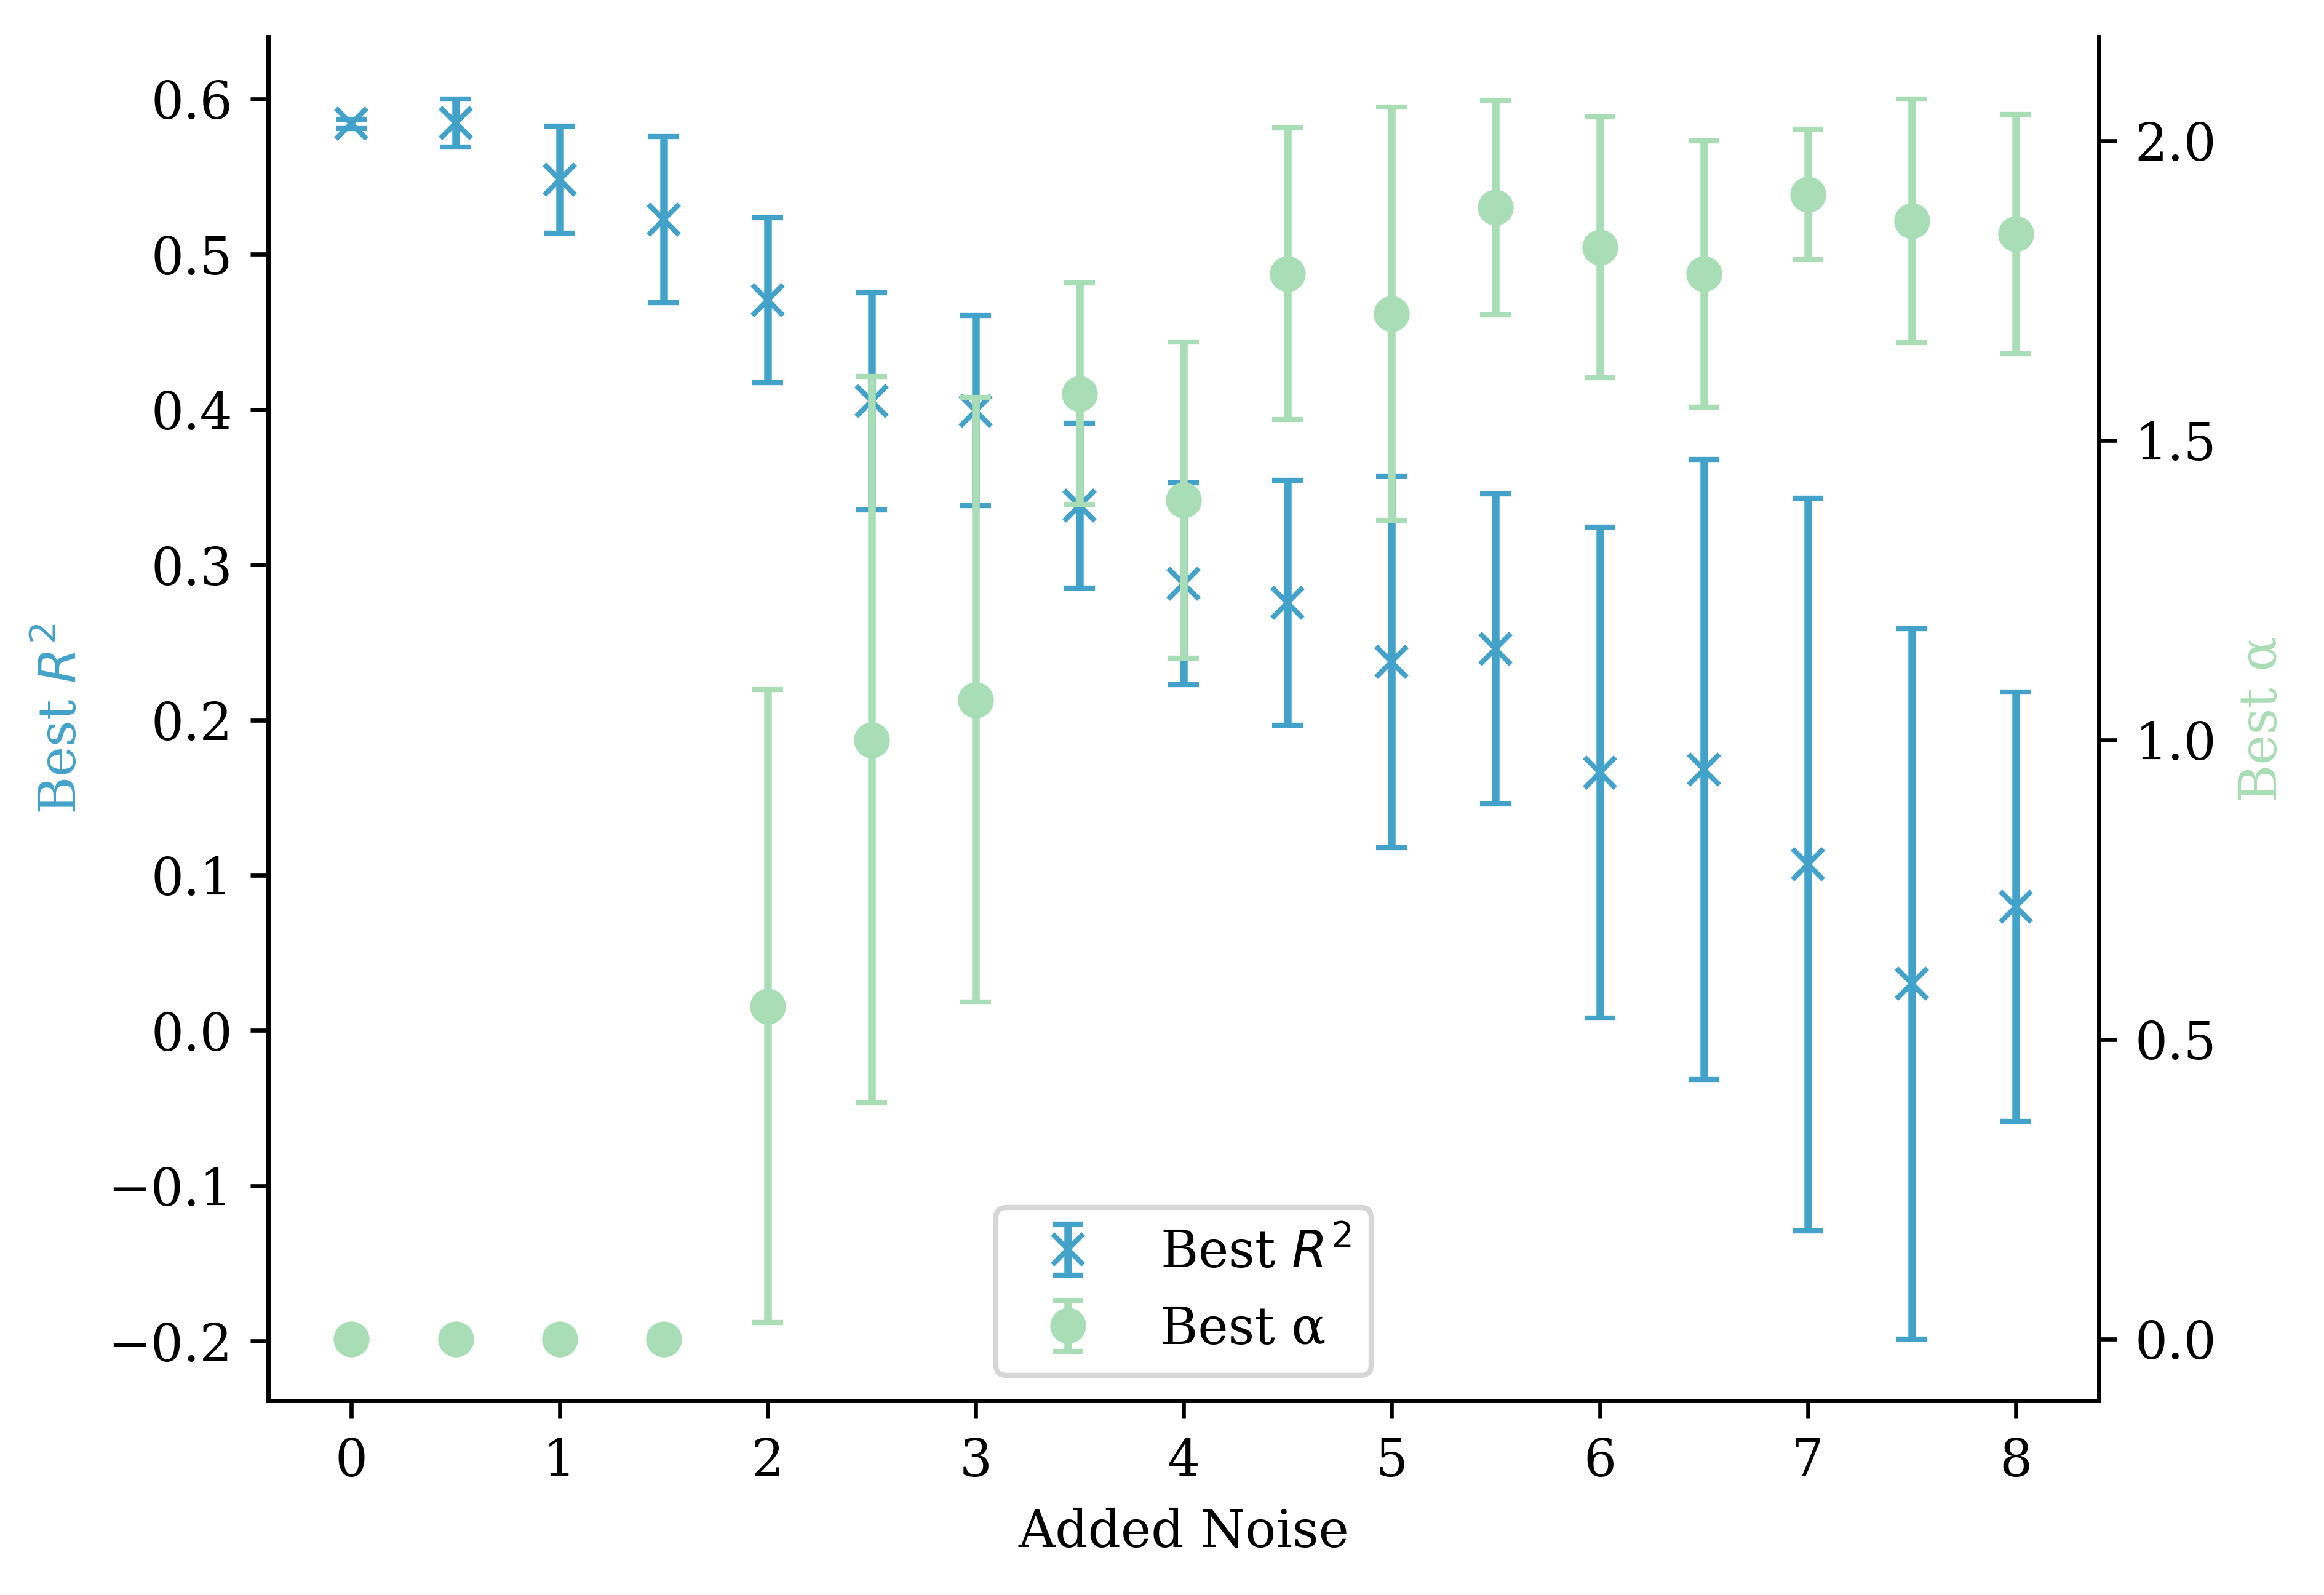

In [25]:
# plot on same axis best points against noise vals and best r2s against noise vals
fig, ax1 = plt.subplots()

ax1.errorbar(noise_vals, best_r2s, yerr=np.transpose(best_r2s_r), color='#43a2ca', fmt='x', capsize=3, label="Best $R^2$")
ax1.set_ylabel("Best $R^2$", color='#43a2ca')
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()



ax2.errorbar(noise_vals, best_points, yerr=np.transpose(best_points_r), color='#a8ddb5', fmt='o', capsize=3, label="Best α")
ax1.set_xlabel("Added Noise")
ax2.spines['top'].set_visible(False)
ax2.set_ylabel("Best α", color='#a8ddb5')

lines, labels = ax1.get_legend_handles_labels() 
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=8)

plt.show()

Table 2

In [4]:
results = {}
coefs ={}
sig_vals = {}

def noise_at_point(x, lims):
    lim1, lim2 = lims
    if lim1[0]>x[0]>lim1[1] and lim2[0]>x[1]>lim2[1]:
        return 5
    else:
        return 1

SMEARS = [0, 0.5, 1, 1.5, 3]
MTRYS = [0.1, 0.3,0.5, 0.7, 1]
POWERS = [0,0.25,0.5,0.75,1,1.5,2]
BOOT_PERC = [0.1, 0.3, 0.5, 0.7, 1]
ALPHAS = [0,0.5,1,2,3,5]


DATA_SEED = 36383
FOREST_SEED = 53432
RANDOM_SEED = 354213


lims = [[[1,0.6],[0.6,0.2]],[[100,60],[408*np.pi,200*np.pi]],[[100,60],[408*np.pi,200*np.pi]]]
datasets = [make_friedman1, make_friedman2, make_friedman3]
noise_types = [0,1]
dataset_n_vals = [1]
noise_vals = [1,3]
TREES = 1000

for dataset_n in dataset_n_vals:
    X,y = datasets[dataset_n-1](2200, noise=0, random_state=DATA_SEED)

    if dataset_n==2:
        y=y/10000
    X_train, X_test, y_train_clean, y_test = train_test_split(X,y, test_size=10/11, random_state=DATA_SEED)
    random_generator = np.random.default_rng(RANDOM_SEED)
    for noise in noise_vals:
        base_noise = noise*np.std(y) # mean of added noise 
        for noise_type in noise_types:
            if noise_type == 0:
                name = f'sim_var_friedman{dataset_n}_uni_noise-{noise}'
                indi_noises = random_generator.uniform(0, 2*base_noise, 200) # only adding noise to training set
            else:
                name = f'sim_var_friedman{dataset_n}_output_dep_noise-{noise}'
                indi_noises = [noise_at_point(i, lims[dataset_n-1]) for i in X_train]
                indi_noises = np.array(indi_noises)*base_noise/np.mean(indi_noises)
                if noise>0:
                    indi_noises = base_noise*np.array(indi_noises)/(np.mean(indi_noises))
                else:
                    indi_noises = [0]*len(indi_noises)
            
            y_train = y_train_clean + [random_generator.normal(0, i) for i in indi_noises]

            results_opt = pickle.load(open(f'results/{name}.pkl', 'rb'))
            results[name] = {}
            coefs[name] = {}
            sig_vals[name] = {}


            # best normal forest
            vals, a = get_best_dict_vals([MTRYS, [0], BOOT_PERC, [0]], results_opt)
            mtry, power, boot_perc, weight_power= vals
            a = []
            model = variable_bootstrap_forest.vbRandomForest(n_estimators=1000, bootstrap=True, max_samples=boot_perc, max_features=mtry, probs_power=power, n_jobs=-1, random_state=FOREST_SEED)

            conv_probs = [np.exp(-i) for i in indi_noises]

            model.fit(X_train, y_train, probs=conv_probs, sample_weight=np.array(conv_probs)**weight_power)
            y_pred_norm = model.predict(X_test)
            results[name]['standard'] = mean_squared_error(y_test, y_pred_norm)
            coefs[name]['standard'] = [mtry, power, weight_power, boot_perc]
            a1 = [(i-j)**2 for i,j in zip(y_pred_norm, y_test)]


            # best paramteric bootstrap 
            vals, a = get_best_dict_vals([MTRYS, POWERS, BOOT_PERC, [0]], results_opt)
            mtry, power, boot_perc, weight_power= vals
            a = []
            
            model = variable_bootstrap_forest.vbRandomForest(n_estimators=1000, bootstrap=True, max_samples=boot_perc, max_features=mtry, probs_power=power, n_jobs=-1, random_state=FOREST_SEED, weight_power=weight_power)
            model.fit(X_train, y_train, probs=conv_probs, sample_weight=np.array(conv_probs))
            y_pred = model.predict(X_test)

            results[name]['parametric bootstrap'] = mean_squared_error(y_test, y_pred)
            coefs[name]['parametric bootstrap'] = [mtry, power, weight_power, boot_perc]

                    
            a2 = [(i-j)**2 for i,j in zip(y_pred, y_test)]
            s_test = ttest_rel(a1,a2, alternative='greater')
            sig_vals[name]['parametric bootstrap'] = s_test.pvalue

            # best weights bootstrap
            vals, a = get_best_dict_vals([MTRYS, [0], BOOT_PERC, POWERS], results_opt)
            mtry, power, boot_perc, weight_power= vals
            a = []
            
            model = variable_bootstrap_forest.vbRandomForest(n_estimators=1000, bootstrap=True, max_samples=boot_perc, max_features=mtry, probs_power=power, n_jobs=-1, random_state=FOREST_SEED, weight_power=weight_power)
            model.fit(X_train, y_train, probs=conv_probs, sample_weight=np.array(conv_probs))
            y_pred = model.predict(X_test)
            results[name]['weighted'] = mean_squared_error(y_test, y_pred)
            coefs[name]['weighted'] = [mtry, power, weight_power, boot_perc]
            a3 = [(i-j)**2 for i,j in zip(y_pred, y_test)]
            s_test = ttest_rel(a1,a3, alternative='greater')
            sig_vals[name]['weighted'] = s_test.pvalue
        
            # output smearing 
            results_os = pickle.load(open(f'results/{name}_os.pkl', 'rb'))
            vals, a = get_best_dict_vals([SMEARS, [0], BOOT_PERC], results_os)
            smear, power, boot_perc = vals
            a = []
            model = osRandomForest(n_estimators=1000, output_smear=smear, bootstrap=True, power_smear=power, max_samples=boot_perc, n_jobs=-1, max_features=1.0, random_state=FOREST_SEED)
            model.fit(X_train, y_train, probs=conv_probs)
            y_pred = model.predict(X_test)
            
            results[name]['output smearing'] = mean_squared_error(y_test, y_pred)
            coefs[name]['output smearing'] = [smear, power, boot_perc]

            a4 = [(i-j)**2 for i,j in zip(y_pred, y_test)]
            s_test = ttest_rel(a1,a4, alternative='greater')
            sig_vals[name]['output smearing'] = s_test.pvalue

    

res_df = pd.DataFrame(results).T
res_df.to_csv('results/sim_var_results.csv')

coef_df = pd.DataFrame(coefs).T
coef_df.to_csv('results/sim_var_coefs.csv')

sig_df = pd.DataFrame(sig_vals).T
sig_df.to_csv('results/sim_var_sig.csv')

res_df.head(8)

,standard,parametric bootstrap,weighted,output smearing
sim_var_friedman1_uni_noise-1,6.599421,5.062218,5.811575,5.741154
sim_var_friedman1_output_dep_noise-1,11.371883,8.496565,9.876741,10.892777
sim_var_friedman1_uni_noise-3,14.556704,7.448416,11.564646,11.359356
sim_var_friedman1_output_dep_noise-3,23.329650,14.945434,19.222746,31.346942


In [11]:
results = {}
coefs ={}
sig_vals = {}

def noise_at_point(x, lims):
    lim1, lim2 = lims
    if lim1[0]>x[0]>lim1[1] and lim2[0]>x[1]>lim2[1]:
        return 5
    else:
        return 1

SMEARS = [0, 0.5, 1, 1.5, 3]
MTRYS = [0.1, 0.3,0.5, 0.7, 1]
POWERS = [0,0.25,0.5,0.75,1,1.5,2]
BOOT_PERC = [0.1, 0.3, 0.5, 0.7, 1]
ALPHAS = [0,0.5,1,2,3,5]


DATA_SEED = 36383
FOREST_SEED = 53432
RANDOM_SEED = 354213


lims = [[[1,0.6],[0.6,0.2]],[[100,60],[408*np.pi,200*np.pi]],[[100,60],[408*np.pi,200*np.pi]],[[1000,0.6],[1,0]]]
datasets = [False, False, False, make_regression]
noise_types = [0,1]
dataset_n_vals = [4]
noise_vals = [1,3]
TREES = 1000

for dataset_n in dataset_n_vals:
    X,y = datasets[dataset_n-1](2200, noise=0, random_state=DATA_SEED)
    y = y/np.std(y)
    X_train, X_test, y_train_clean, y_test = train_test_split(X,y, test_size=10/11, random_state=DATA_SEED)
    random_generator = np.random.default_rng(RANDOM_SEED)
    for noise in noise_vals:
        base_noise = noise*np.std(y) # mean of added noise 
        for noise_type in noise_types:
            if noise_type == 0:
                name = f'sim_var_friedman{dataset_n}_uni_noise-{noise}'
                indi_noises = random_generator.uniform(0, 2*base_noise, 200) # only adding noise to training set
            else:
                name = f'sim_var_friedman{dataset_n}_output_dep_noise-{noise}'
                indi_noises = [noise_at_point(i, lims[dataset_n-1]) for i in X_train]
                indi_noises = np.array(indi_noises)*base_noise/np.mean(indi_noises)
                if noise>0:
                    indi_noises = base_noise*np.array(indi_noises)/(np.mean(indi_noises))
                else:
                    indi_noises = [0]*len(indi_noises)
            
            y_train = y_train_clean + [random_generator.normal(0, i) for i in indi_noises]

            results_opt = pickle.load(open(f'results/{name}.pkl', 'rb'))
            results[name] = {}
            coefs[name] = {}
            sig_vals[name] = {}


            # best normal forest
            vals, a = get_best_dict_vals([MTRYS, [0], BOOT_PERC, [0]], results_opt)
            mtry, power, boot_perc, weight_power= vals
            a = []
            model = variable_bootstrap_forest.vbRandomForest(n_estimators=1000, bootstrap=True, max_samples=boot_perc, max_features=mtry, probs_power=power, n_jobs=-1, random_state=FOREST_SEED)

            conv_probs = [np.exp(-i) for i in indi_noises]

            model.fit(X_train, y_train, probs=conv_probs, sample_weight=np.array(conv_probs)**weight_power)
            y_pred_norm = model.predict(X_test)
            results[name]['standard'] = mean_squared_error(y_test, y_pred_norm)
            coefs[name]['standard'] = [mtry, power, weight_power, boot_perc]
            a1 = [(i-j)**2 for i,j in zip(y_pred_norm, y_test)]


            # best paramteric bootstrap 
            vals, a = get_best_dict_vals([MTRYS, POWERS, BOOT_PERC, [0]], results_opt)
            mtry, power, boot_perc, weight_power= vals
            a = []
            
            model = variable_bootstrap_forest.vbRandomForest(n_estimators=1000, bootstrap=True, max_samples=boot_perc, max_features=mtry, probs_power=power, n_jobs=-1, random_state=FOREST_SEED)
            model.fit(X_train, y_train, probs=conv_probs, sample_weight=np.array(conv_probs)**weight_power)
            y_pred = model.predict(X_test)

            results[name]['parametric bootstrap'] = mean_squared_error(y_test, y_pred)
            coefs[name]['parametric bootstrap'] = [mtry, power, weight_power, boot_perc]

                    
            a2 = [(i-j)**2 for i,j in zip(y_pred, y_test)]
            s_test = ttest_rel(a1,a2, alternative='greater')
            sig_vals[name]['parametric bootstrap'] = s_test.pvalue

            # best weights bootstrap
            vals, a = get_best_dict_vals([MTRYS, [0], BOOT_PERC, POWERS], results_opt)
            mtry, power, boot_perc, weight_power= vals
            a = []
            
            model = variable_bootstrap_forest.vbRandomForest(n_estimators=1000, bootstrap=True, weight_power=weight_power, max_samples=boot_perc, max_features=mtry, probs_power=power, n_jobs=-1, random_state=FOREST_SEED)
            model.fit(X_train, y_train, probs=conv_probs, sample_weight=np.array(conv_probs))
            y_pred = model.predict(X_test)
            results[name]['weighted'] = mean_squared_error(y_test, y_pred)
            coefs[name]['weighted'] = [mtry, power, weight_power, boot_perc]
            a3 = [(i-j)**2 for i,j in zip(y_pred, y_test)]
            s_test = ttest_rel(a1,a3, alternative='greater')
            sig_vals[name]['weighted'] = s_test.pvalue
        
            # output smearing 
            results_os = pickle.load(open(f'results/{name}_os.pkl', 'rb'))
            vals, a = get_best_dict_vals([SMEARS, [0], BOOT_PERC], results_os)
            smear, power, boot_perc = vals
            a = []
            model = osRandomForest(n_estimators=1000, output_smear=smear, bootstrap=True, power_smear=power, max_samples=boot_perc, n_jobs=-1, max_features=1.0, random_state=FOREST_SEED)
            model.fit(X_train, y_train, probs=conv_probs)
            y_pred = model.predict(X_test)
            
            results[name]['output smearing'] = mean_squared_error(y_test, y_pred)
            coefs[name]['output smearing'] = [smear, power, boot_perc]

            a4 = [(i-j)**2 for i,j in zip(y_pred, y_test)]
            s_test = ttest_rel(a1,a4, alternative='greater')
            sig_vals[name]['output smearing'] = s_test.pvalue

            conv_probs2 = [1/i for i in indi_noises]
            # linear model 
            results_linear = pickle.load(open(f'results/{name}_linear.pkl', 'rb'))
            vals, a = get_best_dict_vals([ALPHAS, POWERS], results_linear)

            alpha, power = vals
            power = 1
            model = Ridge(alpha=alpha, random_state=FOREST_SEED)
            model.fit(X_train, y_train, sample_weight=np.array(conv_probs2)**power)
            y_pred = model.predict(X_test)

            results[name]['linear'] = mean_squared_error(y_test, y_pred)
            coefs[name]['linear'] = [alpha, power]

            a5 = [(i-j)**2 for i,j in zip(y_pred, y_test)]
            s_test = ttest_rel(a1,a5, alternative='greater')
            sig_vals[name]['linear'] = s_test.pvalue

            vals, b = get_best_dict_vals([ALPHAS, [0]], results_linear)
            alpha, power = vals
            model = Ridge(alpha=alpha, random_state=FOREST_SEED)
            model.fit(X_train, y_train, sample_weight=np.array(conv_probs2)**power)
            y_pred = model.predict(X_test)

            results[name]['linear_no'] = mean_squared_error(y_test, y_pred)
            coefs[name]['linear_no'] = [alpha, power]

            a6 = [(i-j)**2 for i,j in zip(y_pred, y_test)]
            s_test = ttest_rel(a1,a6, alternative='greater')
            sig_vals[name]['linear_no'] = s_test.pvalue

    
res_df = pd.DataFrame(results).T
res_df.to_csv('results/linear_sim_var_results.csv')

coef_df = pd.DataFrame(coefs).T
coef_df.to_csv('results/linear_sim_var_coefs.csv')

sig_df = pd.DataFrame(sig_vals).T
sig_df.to_csv('results/linear_sim_var_sig.csv')

res_df.head(8)

,standard,parametric bootstrap,weighted,output smearing,linear,linear_no
sim_var_friedman4_uni_noise-1,0.472109,0.472109,0.472109,0.461664,0.662487,0.874799
sim_var_friedman4_output_dep_noise-1,0.546560,0.450012,0.440955,0.570100,1.222047,2.907186
sim_var_friedman4_uni_noise-3,1.068583,1.068583,1.081898,1.053504,10.031115,13.389053
sim_var_friedman4_output_dep_noise-3,0.884758,0.657063,0.668548,0.916124,4.790293,6.487949


Table 3

In [8]:
def get_training_data(source, n_good=5, n2=50):   

    data_good = [pd.read_csv(f'{source}good_part{i}.csv') for i in range(n_good)]
    data_reg = [pd.read_csv(f'{source}regular_part{i}.csv') for i in range(n2)]

    data = data_good + data_reg

    test_data_good = [pd.read_csv(f'{source}good_part{i}.csv') for i in range(5, 5+n_good)]
    test_data_reg = [pd.read_csv(f'{source}regular_part{i}.csv') for i in range(50, 100)]
    
    test_data = test_data_good + test_data_reg

    training_X = []
    training_y = []
    training_y_cert = []

    for i in data:
        training_X += list(i.iloc[:, :1024].values)
        training_y += list(i.iloc[:, 1024:-1].values.T[0])
        training_y_cert += list(i.iloc[:, -1].values.T)

    training_y_vars = 1/np.array(training_y_cert)
    training_y_cert = [np.exp(-i) for i in training_y_vars]
    
    test_X = []
    test_y = []
    test_y_cert = []

    for i in test_data:
        test_X += list(i.iloc[:, :1024].values)
        test_y += list(i.iloc[:, 1024:-1].values.T[0])
        test_y_cert += list(i.iloc[:, -1].values.T)
    return training_X, training_y, training_y_cert, test_X, test_y, test_y_cert

In [5]:
def test_model(params, X_train, y_train, y_train_con, X_test, y_test, trees, y_test_cert, mse=False, preds=False):
    mtry, power, boot_perc, weight_power = params
    model = variable_bootstrap_forest.vbRandomForest(n_estimators=trees, bootstrap=True, max_samples=boot_perc, max_features=mtry, probs_power=power, n_jobs=-1, random_state=234, weight_power=weight_power)
    model.fit(X_train, y_train, probs=y_train_con, sample_weight=np.array(y_train_con))
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred, sample_weight=y_test_cert)
    uw_r2 = r2_score(y_test, y_pred)
    u3 = mean_squared_error(y_test, y_pred)
    if mse:
        return u3
    if preds:
        return uw_r2, y_pred
    return r2, uw_r2

def test_os_model(params, X_train, y_train, y_train_con, X_test, y_test, trees, y_test_cert, preds=False):
    smear, power, boot_perc = params
    model = osRandomForest(n_estimators=trees, output_smear=smear, bootstrap=True, power_smear=power, max_samples=boot_perc, n_jobs=-1, max_features=1.0, random_state=234)
    model.fit(X_train, y_train, probs=y_train_con)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred, sample_weight=y_test_cert)
    uw_r2 = r2_score(y_test, y_pred)
    if preds:
        return uw_r2, y_pred
    return r2, uw_r2

In [4]:
SMEARS = [0.5, 1, 1.5, 2]
MTRYS = [0.05, 0.15, 0.3]
POWERS = [0, 0.25,0.5,0.75,1,1.5,2]
BOOT_PERC = [0.15, 0.3,0.45, 0.6]
     

def model_comp(source, good=1):
    source = 'new_data/'+source
    res_source = 'new_data/results/'+source[-5:-1]+f'_{good}'

    with open(res_source+'.pkl', 'rb') as f:
        res = pickle.load(f)

    with open(res_source+'os.pkl', 'rb') as f:
        res_os = pickle.load(f)

    training_X, training_y, training_y_cert, test_X, test_y, test_y_cert = get_training_data(source, n_good=good)
    z2 = get_best_dict_vals([MTRYS, [0], BOOT_PERC, [0]], res)[0]
    z3 = get_best_dict_vals([MTRYS, POWERS, BOOT_PERC, [0]], res)[0]
    z4 = get_best_dict_vals([MTRYS, [0], BOOT_PERC, POWERS], res)[0]
    z5 = get_best_dict_vals([SMEARS, POWERS, BOOT_PERC], res_os)[0]
    print(z3)
    s2, p2 = test_model(z2, training_X, training_y, training_y_cert, test_X, test_y, 400, test_y_cert, preds=True)
    s3, p3 = test_model(z3, training_X, training_y, training_y_cert, test_X, test_y, 400, test_y_cert, preds=True)
    s4, p4 = test_model(z4, training_X, training_y, training_y_cert, test_X, test_y, 400, test_y_cert, preds=True)
    s5, p5 = test_os_model(z5, training_X, training_y, training_y_cert, test_X, test_y, 400, test_y_cert, preds=True)

    a2 = [(i-j)**2 for i,j in zip(p2, test_y)]
    a3 = [(i-j)**2 for i,j in zip(p3, test_y)]
    a4 = [(i-j)**2 for i,j in zip(p4, test_y)]
    a5 = [(i-j)**2 for i,j in zip(p5, test_y)]

    s_test = ttest_rel(a2,a3, alternative='greater').pvalue
    s_test2 = ttest_rel(a2,a4, alternative='greater').pvalue
    s_test3 = ttest_rel(a2,a5, alternative='greater').pvalue
   
    res = [s2, s3, s4, s5]
    sigs = ['-', s_test, s_test2, s_test3]
    
    return(res, sigs)



In [5]:
sources = ['652039/652039_and_686949_','DAX1/DAX1','720582/720582_and_743254_','720704/720704_and_743261_','scp1/scp1_','gli_sufu/gli_sufu_','TARR1/TARR1_','CRF-R2/CRF-R2_', 'PAFAH1B2/PAFAH1B2_','EBI2/EBI2_', 'PFG/PFG_']
res_1 = []
sig_1 = []
for source in sources:
    z = source.split('/')
    print(z[0])
    a,b = model_comp(source, 1)
    res_1.append(a)
    sig_1.append(b)

df = pd.DataFrame(res_1, index=sources, columns=['standard', 'parametric', 'weighted', 'output smearing'])
df2 = pd.DataFrame(sig_1, index=sources, columns=['standard', 'parametric', 'weighted', 'output smearing'])
df.to_csv('results/real_data_results1.csv')
df2.to_csv('results/real_data_sig1.csv')


652039
(0.05, 2, 0.6, 0)
DAX1
(0.05, 0, 0.6, 0)
720582
(0.3, 0, 0.6, 0)
720704
(0.3, 0.25, 0.6, 0)
scp1
(0.15, 0.75, 0.6, 0)
gli_sufu
(0.05, 1, 0.6, 0)
TARR1
(0.05, 1.5, 0.6, 0)
CRF-R2
(0.15, 1.5, 0.6, 0)
PAFAH1B2
(0.15, 2, 0.6, 0)
EBI2
(0.05, 2, 0.6, 0)
PFG
(0.3, 2, 0.6, 0)
